In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re

In [3]:
df1 = pd.read_csv("./dreaddit-test.csv")
df2 = pd.read_csv("./dreaddit-train.csv")

In [4]:
df = pd.concat([df2, df1], ignore_index=True)
df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1.535936e+09,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1.516430e+09,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1.539809e+09,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [5]:
df.shape

(3553, 116)

In [6]:
df.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label',
       'confidence', 'social_timestamp', 'social_karma', 'syntax_ari',
       ...
       'lex_dal_min_pleasantness', 'lex_dal_min_activation',
       'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment'],
      dtype='object', length=116)

## Preprocessing 

In [7]:
df.isnull().sum()

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64

In [8]:
df = df.loc[:, ['text', 'label']]
df.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [9]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    def denoise_and_tokenize(text):
        # Strip HTML tags and replace contractions
        soup = BeautifulSoup(text, "html.parser")
        text = contractions.fix(soup.get_text())
        # Tokenize tweet into words
        return nltk.word_tokenize(text)

    def remove_non_ascii(words):
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]

    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = [word.lower() for word in words]
        words = [re.sub(r'[^\w\s]', '', word) for word in words if word != '']
        words = [inflect.engine().number_to_words(word) if word.isdigit() else word for word in words]
        if remove_stopwords:
            stop_words = set(stopwords.words('english'))
            words = [word for word in words if word not in stop_words]
        words = lemmatize_verbs(words)
        return words

    def lemmatize_verbs(words):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, pos='v') for word in words]

    def text_prepare(text):
        if not isinstance(text, str):
            return ''
        words = normalize_text(denoise_and_tokenize(text), remove_stopwords)
        return ' '.join(words) if words else ''

    df[text_col] = [text_prepare(x) for x in df[text_col]]
    return df

In [10]:
df["label"]=df["label"].map({0: "No Stress", 1: "Stress"})
df.head()

,text,label
0,"He said he had not felt that way before, sugge...",Stress
1,"Hey there r/assistance, Not sure if this is th...",No Stress
2,My mom then hit me with the newspaper and it s...,Stress
3,"until i met my new boyfriend, he is amazing, h...",Stress
4,October is Domestic Violence Awareness Month a...,Stress


In [11]:
print("Before Text Preprocessing")
display(df.head()[['text']])
processed_df = text_preprocessing_platform(df, 'text', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['text']])

Before Text Preprocessing


,text
0,"He said he had not felt that way before, sugge..."
1,"Hey there r/assistance, Not sure if this is th..."
2,My mom then hit me with the newspaper and it s...
3,"until i met my new boyfriend, he is amazing, h..."
4,October is Domestic Violence Awareness Month a...


C:\Users\Soumya\AppData\Local\Temp\ipykernel_26644\579384670.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


After Text Preprocessing


,text
0,he say he have not felt that way before sugge...
1,hey there rassistance not sure if this be the...
2,my mom then hit me with the newspaper and it s...
3,until i meet my new boyfriend he be amaze he...
4,october be domestic violence awareness month a...


In [12]:
from textblob import TextBlob

def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [13]:
df["sentiment"]=df["text"].apply(detect_sentiment)
df.head()

,text,label,sentiment
0,he say he have not felt that way before sugge...,Stress,-0.019066
1,hey there rassistance not sure if this be the...,No Stress,0.266964
2,my mom then hit me with the newspaper and it s...,Stress,0.067841
3,until i meet my new boyfriend he be amaze he...,Stress,0.195338
4,october be domestic violence awareness month a...,Stress,-0.180769


In [14]:
df.to_csv('processed_data.csv', index=False)

## EDA

<Axes: xlabel='label', ylabel='count'>

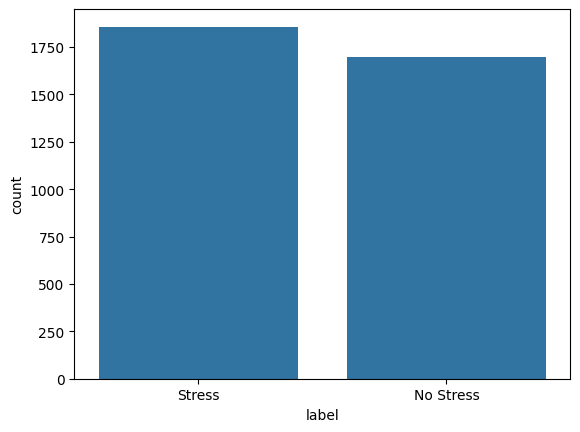

In [15]:
sns.countplot(x=df.label)

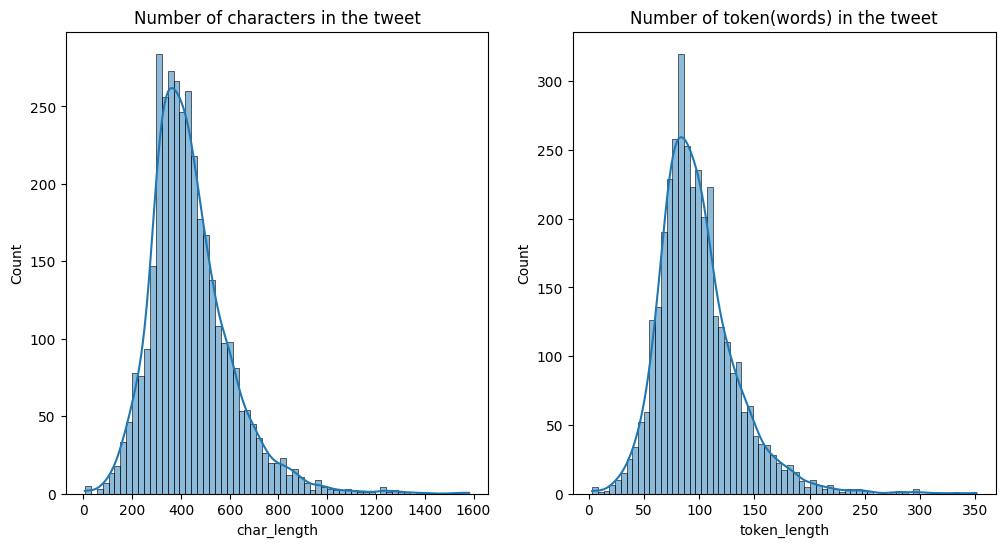

In [16]:
# Calculate character length and token length
df['char_length'] = df['text'].apply(lambda x: len(x))
df['token_length'] = df['text'].apply(lambda x: len(x.split(" ")))

# Plot character length and token length distributions
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.histplot(df['char_length'], ax=ax1, kde=True)
sns.histplot(df['token_length'], ax=ax2, kde=True)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

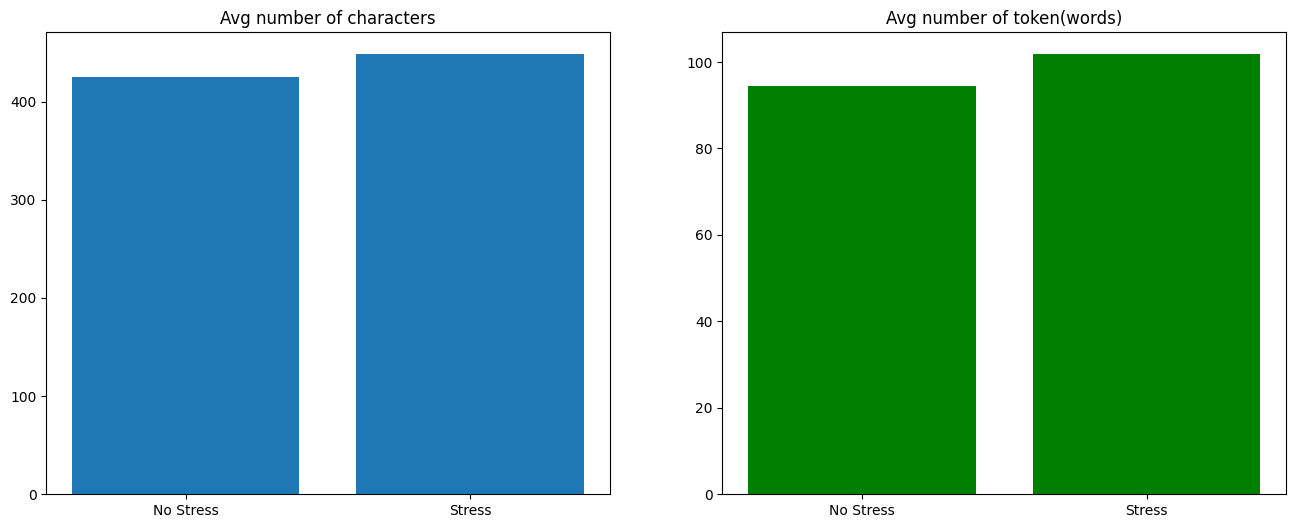

In [17]:
# Calculate average character length and token length per label
avg_df = df.groupby('label').agg({'char_length': 'mean', 'token_length': 'mean'})

# Plot average character length and token length per label
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticks(range(len(avg_df.index)))
ax2.set_xticks(range(len(avg_df.index)))
ax1.set_xticklabels(avg_df.index)
ax2.set_xticklabels(avg_df.index)
plt.show()

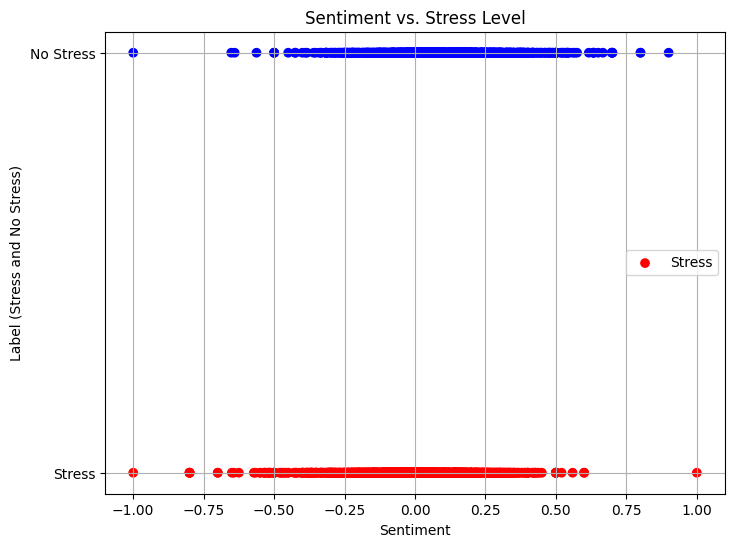

In [18]:
colors = {'Stress': 'red', 'No Stress': 'blue'}

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment'], df['label'], c=df['label'].map(colors))
plt.xlabel('Sentiment')
plt.ylabel('Label (Stress and No Stress)')
plt.title('Sentiment vs. Stress Level')
plt.legend(['Stress', 'No Stress'])
plt.grid(True)
plt.show()

## Models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
x = df['text']
y = df['label']

In [21]:
# vectorizer = CountVectorizer(stop_words='english')
# X = vectorizer.fit_transform(x)

In [22]:
X_train, X_test, y_train, y_test = train_test_split (x,y, test_size=0.33, random_state=1)

In [23]:
# Create a CountVectorizer to convert text into a numerical representation and removing stop words
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_vectorized = vectorizer.transform(X_test)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import f1_score

In [25]:
classifiers = [
    KNeighborsClassifier(15),
    SVC(),
    DecisionTreeClassifier(),
    ExtraTreesClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SGDClassifier(),
    MultinomialNB(),
    GradientBoostingClassifier(),
    BernoulliNB()
]

In [30]:
classifier_names = []
f1_scores = []

for clf in classifiers:
    clf.fit(X_train_vectorized, y_train)
    pred=clf.predict(X_test_vectorized)
    f1 = f1_score(y_test, pred, average='weighted')

    classifier_names.append(str(clf))
    f1_scores.append(f1)
    
    print(clf, f1)

KNeighborsClassifier(n_neighbors=15) 0.5938707632011044
SVC() 0.7330009968572991
DecisionTreeClassifier() 0.6088805983809652
ExtraTreesClassifier() 0.7495167620026353
RandomForestClassifier() 0.7228083255845509
AdaBoostClassifier() 0.6658700151982292
SGDClassifier() 0.7235349716446124
MultinomialNB() 0.7121672272132055
GradientBoostingClassifier() 0.6889763897755146
BernoulliNB() 0.7332495823124591


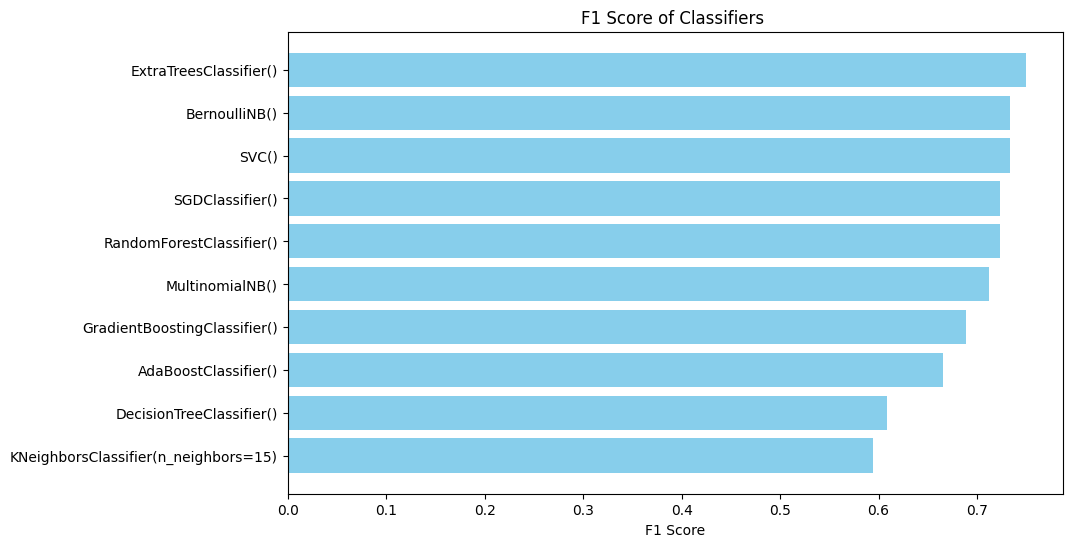

In [31]:
sorted_results = sorted(zip(classifier_names, f1_scores), key=lambda x: x[1], reverse=True)
sorted_classifier_names, sorted_f1_scores = zip(*sorted_results)

plt.figure(figsize=(10, 6))
plt.barh(sorted_classifier_names, sorted_f1_scores, color='skyblue')
plt.xlabel('F1 Score')
plt.title('F1 Score of Classifiers ')
plt.gca().invert_yaxis() 
plt.show()

## Extra Trees Classifier - 0.7421

In [ ]:
classifiers[3].fit(X_train_vectorized, y_train)
pred=classifiers[3].predict(X_test_vectorized)
print(classifiers[3], f1_score(y_test, pred,average='weighted'))

ExtraTreesClassifier() 0.7323603758384324


In [ ]:
etc = ExtraTreesClassifier(min_samples_leaf=4, min_samples_split=2, max_depth=None, n_estimators=100)
etc.fit(X_train_vectorized, y_train)
y_pred = etc.predict(X_test_vectorized)
accuracy = f1_score(y_test, y_pred,average='weighted')
print("Accuracy:", accuracy)

Accuracy: 0.7341499528873334


## Bernoulli NB - 0.7332

In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train_vectorized, y_train)
y_pred = bnb.predict(X_test_vectorized)
accuracy = f1_score(y_test, y_pred,average='weighted')
print("Accuracy:", accuracy)

Accuracy: 0.7332495823124591


## Random Forest Classifier - 0.7366

In [ ]:
rfc = RandomForestClassifier(max_depth= None, min_samples_leaf= 4, min_samples_split= 5, n_estimators= 150)
rfc.fit(X_train_vectorized, y_train)
y_pred = rfc.predict(X_test_vectorized)
accuracy = f1_score(y_test, y_pred,average='weighted')
print("Accuracy:", accuracy)

Accuracy: 0.7366122610072471


## SVC - 0.7332

In [35]:
svc = SVC(C=100, gamma = "auto", kernel= "sigmoid")
svc.fit(X_train_vectorized, y_train)
y_pred = svc.predict(X_test_vectorized)
accuracy = f1_score(y_test, y_pred,average='weighted')
print("Accuracy:", accuracy)

Accuracy: 0.7332877939986407


## Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# etc = ExtraTreesClassifier()

# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(estimator=etc, param_grid=param_grid, cv=5, scoring='f1_weighted')

# grid_search.fit(X_train_vectorized, y_train)

# print("Best Parameters:", grid_search.best_params_)

# best_etc = grid_search.best_estimator_

# y_pred = best_etc.predict(X_test_vectorized)

# accuracy = f1_score(y_test, y_pred, average='weighted')
# print("Best Model Accuracy:", accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Accuracy: 0.7434021313392422


In [ ]:
# from sklearn.model_selection import GridSearchCV

# bnb = BernoulliNB()

# param_grid = {
#     'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
#     'binarize': [0.0, 0.1, 0.5, 1.0]  # Threshold for binarizing input features
# }

# # Perform grid search cross-validation
# grid_search = GridSearchCV(estimator=bnb, param_grid=param_grid, cv=5, scoring='f1_weighted')

# # Fit the grid search to the data
# grid_search.fit(X_train_vectorized, y_train)

# # Print the best parameters found
# print("Best Parameters:", grid_search.best_params_)

# # Get the best estimator
# best_bnb = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_bnb.predict(X_test_vectorized)

# # Calculate accuracy
# accuracy = f1_score(y_test, y_pred, average='weighted')
# print("Best Model Accuracy:", accuracy)

Best Parameters: {'alpha': 0.5, 'binarize': 0.0}
Best Model Accuracy: 0.733276358493502


In [ ]:
# from sklearn.model_selection import GridSearchCV

# rfc = RandomForestClassifier()

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform grid search cross-validation
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='f1_weighted')

# # Fit the grid search to the data
# grid_search.fit(X_train_vectorized, y_train)

# # Print the best parameters found
# print("Best Parameters:", grid_search.best_params_)

# # Get the best estimator
# best_rfc = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_rfc.predict(X_test_vectorized)

# # Calculate accuracy
# accuracy = f1_score(y_test, y_pred, average='weighted')
# print("Best Model Accuracy:", accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
Best Model Accuracy: 0.7353170599292178


In [33]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
#     'gamma': ['scale', 'auto']  # Kernel coefficient
# }

# svc = SVC()

# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1_weighted')

# grid_search.fit(X_train_vectorized, y_train)

# # Print the best parameters found
# print("Best Parameters:", grid_search.best_params_)

# # Get the best estimator
# best_rfc = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_rfc.predict(X_test_vectorized)

# # Calculate accuracy
# accuracy = f1_score(y_test, y_pred, average='weighted')
# print("Best Model Accuracy:", accuracy)


Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}
Best Model Accuracy: 0.7332877939986407


## Predict

In [ ]:
new_text_entry = "Im having a very good time!! but i think the overall experience is slightly tragic, dont you think?"

new_text_entry_vectorized = vectorizer.transform([new_text_entry])

predicted_class = etc.predict(new_text_entry_vectorized)
probability = etc.predict_proba(new_text_entry_vectorized)

probability_stressed = probability[0][1] 

print("Predicted Class:", predicted_class)
print("Probability Estimates:",  probability_stressed)

Predicted Class: ['No Stress']
Probability Estimates: 0.3747919334956044


In [ ]:
new_text_entry = "Horrible! i had a bad day. i am very very stressed. exams are coming. i am not prepared. "

new_text_entry_vectorized = vectorizer.transform([new_text_entry])

predicted_class = etc.predict(new_text_entry_vectorized)
probability = etc.predict_proba(new_text_entry_vectorized)

probability_stressed = probability[0][1] 

print("Predicted Class:", predicted_class)
# print("Probability Estimates:",  probability_stressed)

Predicted Class: ['Stress']


## Make a Pickle 

In [ ]:
import pickle

with open('../App/stress_model.pkl', 'wb') as file:
    pickle.dump(etc, file)

In [ ]:
with open('../App/stress_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)